# Next Steps

### Using extract_text_lines() on orig_pdf: 
1.  Identify lines that are separated but shouldn't be using "top" and "bottom" (overlapping lines should be combined)
2.  Convolve a window of width=text_width, height=full_window_height across width of the page to find the position of the text that should be combined
3.  Combine the text and adjust the position metadata accordingly

### Also check if extract_text_lines() would pull out text that is missing from the ocr_pdf
1. Look at ground_space_requirements for New_ocr_pdf, model # in first equipment specfications tables in Old_ocr_pdf

In [ ]:
%pip install pdfminer.six
%pip install pdfplumber
%pip install numpy pandas
%pip install textdistance
%pip install regex
%pip install strictyaml


In [9]:
%pip install pyyaml

   ---------------------------------------- 0.0/138.7 kB ? eta -:--:--
   -- ------------------------------------- 10.2/138.7 kB ? eta -:--:--
   ----------- --------------------------- 41.0/138.7 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 138.7/138.7 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure
# To extract text from tables in PDF
import pdfplumber
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Optional, Iterable, Dict, Tuple
import regex
from textdistance import hamming, jaro, levenshtein
import strictyaml 
import yaml

In [2]:
from io import StringIO

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

In [49]:
class pdf_data():
    def __init__(self, orig_filepath: str | Path, ocr_filepath: str | Path, config: str | Path) -> None:
        self.orig_filepath = orig_filepath
        self.ocr_filepath = ocr_filepath
        self.config = config     

    def get_text_containers_from_ocr(self, pages: Optional[Iterable[int]] = None) -> pd.DataFrame:
        text_dict = dict(page=[], y_bottom=[], y_top=[], x_left=[], x_right=[], width=[], text=[],)
        for page_idx, page_layout in enumerate(extract_pages(self.ocr_filepath)):
            for el_idx, element in enumerate(page_layout):
                if isinstance(element, LTTextContainer):
                    text_dict['page'].append(page_idx)
                    text_dict['y_bottom'].append(element.y0)
                    text_dict['y_top'].append(element.y1)
                    text_dict['x_left'].append(element.x0)
                    text_dict['x_right'].append(element.x1)
                    text_dict['width'].append(element.width)
                    text_dict['text'].append(element.get_text().lower().replace('\n', ''))
                elif isinstance(element, LTRect):
                    print(f'page = {page_idx}, ypos={element.y0}, type={type(element)}')
                else:
                    print(f'page = {page_idx}, ypos={element.y0}, type={type(element)}')

        self.text_df = pd.DataFrame(text_dict)
        self.text_df['norm_y_top']    = self.text_df['page'] + ((page_layout.height - self.text_df['y_top'   ]) / page_layout.height)
        self.text_df['norm_y_bottom'] = self.text_df['page'] + ((page_layout.height - self.text_df['y_bottom']) / page_layout.height)
        # y_min, y_max = self.text_df['y_bottom'].min(), self.text_df['y_top'].max()
        # self.text_df['norm_y_top']    = self.text_df['page'] + ((y_max - self.text_df['y_top'   ]) / (y_max - y_min))
        # self.text_df['norm_y_bottom'] = self.text_df['page'] + ((y_max - self.text_df['y_bottom']) / (y_max - y_min))
        # self.text_df['norm_y_top']    = self.text_df['page'] + ((self.text_df['y_bottom'] - y_min) / y_max)

        self.text_df.sort_values(by='norm_y_top', inplace=True, ignore_index=True, ascending=True)

    def get_section_headers(self):
        with open(self.config, 'r') as file:
            self.config_data = yaml.safe_load(file) 
        
        self.sections = dict()
        for section in self.config_data['sections']:
            self.sections[section['header']] = dict(bounds = pd.DataFrame(),
                                                    extract = section['extract'])

    def get_section_bounds(self):

        self.get_section_headers()

        # detect start and end of sections
        prev_section_info = dict(header=None, df_row=None)
        prev_page = 0
        for row_idx, text_data in self.text_df.iterrows():
            detected_section = None
            for header in self.sections.keys():
                match = regex.search(f'{header}{{s<=3,i<=3,d<=3}}', text_data['text'], regex.BESTMATCH)    
                if match is not None:
                    detected_section = header
                    break

            if text_data['page'] > prev_page or detected_section is not None:
                if prev_section_info['header'] is not None:   # store end of sections
                    prev_df_idx = self.sections[prev_section_info['header']]['bounds'].index[-1] 
                    prev_bottom = prev_page+0.9999 if (text_data['page'] > prev_page) else text_data['norm_y_top'] 
                    self.sections[prev_section_info['header']]['bounds'].loc[prev_df_idx, ['y_bottom',]] = [prev_bottom]
                # store start of sections
                top = text_data['page'] if (text_data['page'] > prev_page) else text_data['norm_y_top']
                tmp_df = pd.DataFrame(data    = zip([top], [np.nan],),
                                      columns = ['y_top', 'y_bottom',],)
                header = detected_section
                self.sections[header]['bounds'] = pd.concat((self.sections[header]['bounds'], tmp_df), ignore_index=True)
                prev_section_info['header'] = header
                if text_data['page'] > prev_page:
                    prev_page+=1
            prev_section_info['df_row'] = row_idx
        
        # store end of final section
        prev_y_bottom = self.text_df.loc[prev_section_info['df_row'], 'norm_y_bottom']
        prev_df_idx = self.sections[prev_section_info['header']]['bounds'].index[-1] 
        self.sections[prev_section_info['header']]['bounds'].loc[prev_df_idx, ['y_bottom',]] = [np.ceil(prev_y_bottom),]
    
    def extract_table(self, subsection_bounds):  
        page_num = int(np.floor(subsection_bounds['y_top'])) 
        pdf = pdfplumber.open(self.orig_filepath)
        table_page = pdf.pages[page_num]
        table_crop = table_page.within_bbox((               0, (subsection_bounds['y_top'   ]-page_num)*table_page.height, 
                                             table_page.width, (subsection_bounds['y_bottom']-page_num)*table_page.height))
        table = table_crop.extract_table()
        # print((subsection_bounds['y_top'   ]-page_num)*table_page.height, (subsection_bounds['y_bottom']-page_num)*table_page.height, table)
        return table
    
    def extract_text_lines_from_original(self, subsection_bounds):
        page_num = int(np.floor(subsection_bounds['y_top'])) 
        pdf = pdfplumber.open(self.orig_filepath)
        page = pdf.pages[page_num]
        page_crop = page.within_bbox((         0, (subsection_bounds['y_top'   ]-page_num)*page.height, 
                                      page.width, (subsection_bounds['y_bottom']-page_num)*page.height))  

        text = page_crop.extract_text_lines()

        for line in text:
            line['norm_y_top']    = page_num + (line['top']    / page.height)
            line['norm_y_bottom'] = page_num + (line['bottom'] / page.height)
            line['page']          = page_num
            line['y_bottom']      = page.height - line['bottom']
            line['y_top']         = page.height - line['top']
            line['text'] = line['text'].lower()

        return text  

    def table_to_df(self, 
                    table: List[List[str]], 
                    extract_params: str | Dict | List[Dict],
                    ) -> pd.DataFrame:
        if type(extract_params) == str and 'col' in extract_params.lower():
            info_keys = list()
            data = list()
            for row in table:
                iKey = row.pop(0)
                info_keys.append(iKey)
                data.append(row)
            df = pd.DataFrame(data=np.array(data).transpose(), columns=info_keys)

        elif type(extract_params) == str and 'row' in extract_params.lower():
            info_keys = table[0]
            data = table[1:]
            df = pd.DataFrame(data=data, columns=info_keys)

        else:
            print('There is no method implemented for converting data with this extraction method to a DataFrame')
            df = None
        
        return df 

    def get_original_text_missed_by_ocr(self):
        for section_header, section_dict in self.sections.items():
            for sub_idx, subsection_bounds in section_dict['bounds'].iterrows():    
                
                if 'data' in section_dict.keys() and type(section_dict['data']) == pd.DataFrame:
                    continue
                
                text = self.extract_text_lines_from_original(subsection_bounds)

                mask = (self.text_df['norm_y_top'   ] > subsection_bounds['y_top'   ]) & \
                       (self.text_df['norm_y_bottom'] < subsection_bounds['y_bottom']) 
                ocr_text_df = self.text_df.loc[mask, :]
                
                for line in text:
                    pos_match = np.where(np.isclose(ocr_text_df['norm_y_top'], line['norm_y_top'], atol = 1e-2))[0]  
                    df_match_idx = ocr_text_df.index[pos_match] 
                    if len(df_match_idx) == 0:
                        tmp_line_dict = dict(page          = [line['page']],
                                             y_bottom      = [line['y_bottom']],
                                             y_top         = [line['y_top']],
                                             x_left        = [line['x0']],
                                             x_right       = [line['x1']],
                                             width         = [line['x1'] - line['x0']],
                                             text          = [line['text']],
                                             norm_y_top    = [line['norm_y_top']],
                                             norm_y_bottom = [line['norm_y_bottom']],)
                        line_df = pd.DataFrame.from_dict(data=tmp_line_dict)
                        self.text_df = pd.concat((self.text_df, line_df), axis=0, ignore_index=True)
                        print(f'Added missing data to {section_header}:\n"{line_df["text"].values[0]}"\n')
                    elif len(df_match_idx) == 1:
                        ocr_line = ocr_text_df.loc[df_match_idx, 'text'].values[0]
                        if line['text'] != ocr_line and levenshtein.normalized_similarity(line['text'], ocr_line) > 0.75:
                            self.text_df.loc[df_match_idx, 'text'] = line['text'] 
                            print(f'replaced text at idx={ocr_text_df.index[pos_match].values[0]}\noriginal text: "{ocr_line}"\nnew text: "{line["text"]}"\n')    
                    else:
                        for idx, ocr_line in ocr_text_df.loc[df_match_idx, 'text'].items():
                            match = regex.search(f'{ocr_line}{{s<=3,i<=1,d<=1}}', line['text'], regex.BESTMATCH)
                            if match is not None:
                                text_match = match.captures()
                                if text_match == ocr_line:
                                    continue
                                elif levenshtein.normalized_similarity(text_match, ocr_line) > 0.75:
                                    self.text_df.loc[idx, 'text'] = text_match
                                    print(f'replaced text at idx={idx}\noriginal text: {ocr_line}\nnew text: {text_match}\n')

        self.text_df.sort_values(by='norm_y_top', inplace=True, ignore_index=True, ascending=True)
 

    def extract_table_data_from_all_sections(self):
        for section_header, section_dict in self.sections.items():
            for sub_idx, subsection_bounds in section_dict['bounds'].iterrows():
                table = self.extract_table(subsection_bounds)
                if table is not None:
                    data_df = self.table_to_df(table, section_dict['extract'])
                    data_df = data_df.loc[:, [col for col in data_df.columns if col.lower() != section_header]]
                    if 'data' in section_dict.keys(): 
                        section_dict['data'] = pd.concat((section_dict['data'], data_df),
                                                         axis=0,
                                                         ignore_index=True)
                    else:
                        section_dict['data'] = data_df

    def extract_key_value_pairs(self, 
                                section_dict: Dict, 
                                subsect_df: pd.DataFrame, 
                                sep: str = ':',
                                ) -> Dict:
        
        section_dict['data'] = dict()
        for l_idx, line in subsect_df.iterrows(): 
            parsed_line = line['text'].split(sep)
            if len(parsed_line) == 2: 
                key, value = parsed_line
                value = value[1:]  if value[0]  == ' '  else value
                value = value[:-1] if value[-1] == '\n' else value
                section_dict['data'][key] = value     
                print(f'{key}{sep} {value}')   
            elif len(parsed_line) > 2:
                new_sep = ' '
                new_split_line = line['text'].split(new_sep)
                key_end_idxs = [idx   for idx, token in enumerate(new_split_line) if token[-1] == sep]
                val_idxs     = [idx+1 for idx in key_end_idxs]
                values       = [val   for idx, val in enumerate(new_split_line) if idx in val_idxs]
                values       = [val[:-1] if val[-1] == '\n' else val for val in values] 
                
                key_start_idxs = [0] + [idx+1 for idx in val_idxs]
                keys = list()
                for start, end in zip(key_start_idxs, key_end_idxs):
                    key = new_sep.join([token for idx, token in enumerate(new_split_line) if idx >= start and idx <= end])
                    keys.append(key)
                keys = [key.replace(sep, '') for key in keys]
                
                for key, value in zip(keys, values):
                    section_dict['data'][key] = value 


    def extract_text_data(self):
        for section_header, section_dict in self.sections.items():
            for sub_idx, subsection_bounds in section_dict['bounds'].iterrows():
                if 'data' in section_dict.keys() and type(section_dict['data']) == pd.DataFrame:
                    self.extract_text_as_table()

                else:
                    mask = (self.text_df['norm_y_top'   ] > subsection_bounds['y_top'   ]) & \
                           (self.text_df['norm_y_bottom'] < subsection_bounds['y_bottom']) 
                    subsect_df = self.text_df.loc[mask, :]
                    self.extract_key_value_pairs(section_dict, subsect_df, sep=':')

    def store_section_data(self, section_header): #TODO
        self.identify_section_structure(section_header)

    def print_text(self):
        max_x = 0
        for page_text in self.text_containers:
            for text_container in page_text:
                if text_container.x1 > max_x:
                    max_x = text_container.x1
        for page_num, page_text in enumerate(self.text_containers):
            print('###############################################')
            print(f'Page {page_num}')
            print('###############################################') 
            for text_container in page_text:  
                text = text_container.get_text()
                # print(f'{text_container.y0} to {text_container.y1}', text)
                print(text_container.y1, text_container.y0, text)


class exhibit_data(pdf_data):
    def __init__(self, orig_filepath: str | Path, ocr_filepath: str | Path,  config: str | Path) -> None:
        super().__init__(orig_filepath, ocr_filepath, config)

    def get_exhibit_name(self):
        for text_container in self.text_containers[0]:
            text = text_container.get_text()
            if 'exhibit' in text.lower():
                pattern = regex.compile(r'^\s+')
                exhibit = pattern.sub('', text.lower().replace('exhibit', '').replace('\n', ''))
                self.exhibit = exhibit
    
    def get_ground_space_requirements(self, keyphrases: List[str]):
        for page_text in self.text_containers:
            examine_text  = False
            get_next_line = True
            line_iter = iter(page_text)
            while get_next_line:
                text_container = line_iter.__next__()
                text = text_container.get_text().lower()
                if examine_text:
                    split_text = text.split(' ')
                    if any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                            or hamming.normalized_similarity(t, 'specifications') > 0.75
                            for t in split_text]):
                        get_next_line = False
                    else:
                        for key in keyphrases:
                            pattern = fr'((?<={key})\w+)'
                            value = regex.findall(f'{pattern}{{e<=3}}', text, regex.BESTMATCH)
                            print(value)
                # elif any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                #           or hamming.normalized_similarity(t, 'specifications') > 0.75
                #             for t in split_text])::

# fuzzy_pattern = f'({pattern}){{e<=3}}'
# text = 'I went to the doctor on 7022-O3-I6.'

# match = regex.search(fuzzy_pattern, text, regex.BESTMATCH)
# match.groupdict()

                else:
                    if hamming.normalized_similarity(text.lower(), 'ground space requirements') > 0.75:
                        examine_text = True
    
    def get_equipment_specifications(self):
        for page_text in self.text_containers:
            examine_text  = False
            get_next_line = True
            line_iter = iter(page_text)
            while get_next_line:
                text_container = line_iter.__next__()
                text = text_container.get_text().lower()
                if examine_text:
                    split_text = text.split(' ')
                    if any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                            or hamming.normalized_similarity(t, 'specifications') > 0.75
                            for t in split_text]):
                        get_next_line = False

                
                

In [50]:
new_ocr_pdf_path  = Path('amendments/New_Exhibit_Redacted_OCR_new.pdf')
new_orig_pdf_path = Path('amendments/New_Exhibit_Redacted.pdf')
old_ocr_pdf_path  = Path('amendments/Old_Exhibit_Redacted_OCR_new.pdf')
old_orig_pdf_path = Path('amendments/Old_Exhibit_Redacted.pdf')

config_path = Path(r'C:\Users\Dalton\Documents\personal_records\apex_consulting\materials_and_amendments_OCR\configs\atc_extra_info_config.yaml')


In [51]:
new_exhibit = exhibit_data(new_orig_pdf_path, new_ocr_pdf_path, config_path)
new_exhibit.get_text_containers_from_ocr()
new_exhibit.get_section_bounds()
new_exhibit.extract_table_data_from_all_sections()
new_exhibit.get_original_text_missed_by_ocr()

# for key in new_exhibit.sections.keys():
#     print(f'\n{key}')
#     print(new_exhibit.sections[key]['bounds'])


page = 0, ypos=-5.348e-06, type=<class 'pdfminer.layout.LTFigure'>
page = 1, ypos=-5.348e-06, type=<class 'pdfminer.layout.LTFigure'>


In [53]:
new_exhibit.extract_text_data()

outside primary lease area n/a n/a n/a sq.ft: n/a
fuel tank setback (radius): n/a
generator: n/a
fuel tank size (gal): n/a
fuel type: n/a
power provided by: utility company direct
telco/interconnect: n/a


AttributeError: 'exhibit_data' object has no attribute 'extract_text_as_table'

In [102]:
new_exhibit.sections['ground space requirements']['data']
new_exhibit.sections['backup power requirements']['data']
new_exhibit.sections['utility requirements']['data']
new_exhibit.sections['transmitter & receiver specifications']['data']
new_exhibit.sections['equipment specifications']['data']

,Type,Manufacturer,Model #,Dimensions\nHxWxD,Weight (lbs.),Location,RAD Center AGL,Tip Height,Base Height,Mount Type,...,Azimuths/Dir. of\nRadiation,Quant. Per\nAzimuth/Sector,TX/RX Frequency\nUnits,TX Frequency,RX Frequency,Using Unlicensed\nFrequencies?,Antenna Gain,Total # of Lines,Individual Line\nConfiguration,Conduit\nConfiguration
0,GPS,Generic,GPS,"12"" x 9"" x 6""",10.0,Ground,N/A,N/A,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,No,N/A,N/A,N/A,N/A
1,PANEL,RFS,APXVAA24_43-U-\nA20,"96"" x 24"" x 8.5""",101.4,Tower,180.0',184.0',176.0',Side Arm,...,60/180/300,1/1/1,MHz,668-688,622-642,No,13.2 / 13.6(cid:9),3,"Qty: 3\nType: Coax\nDiameter: 1/2"" Coax\nAzimu...",N/A
2,PANEL,CellMax,CMA-B/6521/E0-6,"81.1"" x 7.7"" x 4.8""",35.0,Tower,180.0',183.4',176.6',Side Arm,...,60/80/300,2/2/2,MHz,"1930-1945,2145-\n2155,1735-1740","1850-1865,1745-\n1755,2135-2140",No,18.3/ 18.7/ 19.2,6,"Qty: 6\nType: Coax\nDiameter: 1 5/8""\nCoax\nAz...",N/A
3,TTA,RFS,ATM1900D-1CWA,"8.6"" x 10"" x 2.6""",8.4,Tower,180.0',180.4',179.6',Side Arm,...,60/180/300,1/1/1,N/A,N/A,N/A,No,12,1,"Qty: 1\nType: Fiber/Hybrid\nDiameter: 1 5/8""\n...",N/A
4,RRU/RRH,Ericsson,Radio 4478 B71,"15"" x 13.2"" x 7.4""",60.0,Tower,180.0',180.6',179.4',Side Arm,...,60/180/300,1/1/1,N/A,N/A,N/A,No,N/A,3,"Qty: 3\nType: Coax\nDiameter: 1/4"" Coax\nAzimu...",N/A
5,RRU/RRH,Ericsson,RRU22,"20.2"" x 13.2"" x 6.9""",52.9,Tower,180.0',180.8',179.2',Side Arm,...,60,1,MHz,"2145-2155,1735-\n1740","1745-1755,2135-\n2140",No,N/A,2,N/A,"Qty: 1\nType: 2"" conduit\ncontaining:\n-;\nAzi..."
6,RRU/RRH,Ericsson,RRU22,"20.2"" x 13.2"" x 6.9""",52.9,Tower,180.0',180.8',179.2',Side Arm,...,180/300,1/1,MHz,"2145-2155,1735-\n1740","1745-1755,2135-\n2140",No,N/A,3,"Qty: 3\nType: Hard Line\nDiameter: 1/8"" Hard\n...",N/A
7,DISH-HP,Commscope,USX6-6W,6.23' x 6.23' x 4.32',198.0,Tower,155.0',158.1',151.9',Pole Mount,...,292.15,1,GHz,6,6,No,38.3 / 38.8 / 39.3,N/A,N/A,N/A
8,DISH-HP,Commscope,USX10-11W,10' x -' x -',579.8,Tower,155.0',160.0',150.0',Pole Mount,...,184.14,1,GHz,11,1,No,N/A,N/A,N/A,N/A
9,Radio/ODU,Ceragon,RFU-D,"9.1"" x 9.2"" x 3.9""",14.3,Tower,155.0',155.4',154.6',Pole Mount,...,292.15,4,N/A,N/A,N/A,No,N/A,8,"Qty: 4\nType: Control Cable\nDiameter: 0.31"" (...",N/A


In [54]:
old_exhibit = exhibit_data(old_orig_pdf_path, old_ocr_pdf_path, config_path)
old_exhibit.get_text_containers_from_ocr()
old_exhibit.get_section_bounds()

old_exhibit.extract_table_data_from_all_sections()
old_exhibit.get_original_text_missed_by_ocr()

# for key in old_exhibit.sections.keys():
#     print(f'\n{key}')
#     print(old_exhibit.sections[key]['bounds'])

    

page = 0, ypos=7.38e-07, type=<class 'pdfminer.layout.LTFigure'>
page = 1, ypos=-5.348e-06, type=<class 'pdfminer.layout.LTFigure'>


In [58]:
old_exhibit.sections['equipment specifications']['data'].columns

Index(['', 'Type', 'Manufacturer', 'Model #', 'Dimensions HxWxD',
       'Weight(lbs.)', 'Location', 'RAD Center AGL', 'Equipment Tip\nHeight',
       'Equipment Base\nHeight', 'Mount Type', 'Quantity',
       'Azimuths/Dir. of\nRadiation', 'Quant. Per\nAzimuth/Sector',
       'TX/RX Frequency\nUnits', 'TX Frequency', 'RX Frequency',
       'Using Unlicensed\nFrequencies?', 'Equipment Gain', 'Total # of Lines',
       'Line Quant. Per\nAzimuth/Sector', 'Line Type', 'Line Diameter Size',
       'Line Configuration'],
      dtype='object')

In [59]:
new_exhibit.sections['equipment specifications']['data'].columns

Index(['Type', 'Manufacturer', 'Model #', 'Dimensions\nHxWxD', 'Weight (lbs.)',
       'Location', 'RAD Center AGL', 'Tip Height', 'Base Height', 'Mount Type',
       'Quantity', 'Azimuths/Dir. of\nRadiation', 'Quant. Per\nAzimuth/Sector',
       'TX/RX Frequency\nUnits', 'TX Frequency', 'RX Frequency',
       'Using Unlicensed\nFrequencies?', 'Antenna Gain', 'Total # of Lines',
       'Individual Line\nConfiguration', 'Conduit\nConfiguration'],
      dtype='object')

In [63]:
[t for t in new_exhibit.text_df.text]

['exhibit a-4',
 'ground space requirements',
 "total lease area sq.ft: 216.00 primary contiguous lease area l: 12.00' w: 18.00' h: 10.00' sq.ft: 216.00",
 "concrete pad 10.00' 16.00' n/a 160.00",
 'outside primary lease area n/a n/a n/a sq.ft: n/a',
 'backup power requirements',
 'fuel tank setback (radius): n/a',
 'generator: n/a',
 'fuel tank size (gal): n/a',
 'fuel type: n/a',
 'utility requirements',
 'power provided by: utility company direct',
 'telco/interconnect: n/a',
 'transmitter & receiver specifications',
 'type: n/a quantity: n/a tx power (watts): n/a erp power (watts): n/a',
 'equipment specifications',
 'type gps panel panel tta rru/rrh rru/rrh',
 'manufacturer generic rfs cellmax rfs ericsson ericsson',
 'model # gps apxvars 4s-u- cma-b/6521/e0-6 | atm1900d-1cwa | radio 4478 b71 rru22',
 'dimensions 12" x 9" x 6" 96" x 24" x 8.5" 81.1" x 7.7" x 4.8" 8.6"x 10" x 2.6" 15"x 13.2" x 7.4" | 20.2" x 13.2" x 6.9"',
 'weight (ibs.) 10.0 101.4 35.0 8.4 60.0 52.9',
 'location 

In [62]:
page_num = 0

# Open the pdf file
pdf = pdfplumber.open(new_exhibit.orig_filepath)
# Find the examined page
table_page = pdf.pages[page_num]
table_page.to_image()
for line in table_page.extract_text_lines():
    print(line['text'].lower())

exhibit a-4
ground space requirements
total lease area sq.ft: 216.00 primary contiguous lease area l: 12.00' w: 18.00' h: 10.00' sq.ft: 216.00
concrete pad 10.00' 16.00' n/a 160.00
outside primary lease area n/a n/a n/a sq.ft: n/a
backup power requirements
generator: n/a fuel tank size (gal): n/a fuel type: n/a fuel tank setback (radius): n/a
utility requirements
power provided by: utility company direct
telco/interconnect: n/a
transmitter & receiver specifications
type: n/a quantity: n/a tx power (watts): n/a erp power (watts): n/a
equipment specifications
type gps panel panel tta rru/rrh rru/rrh
manufacturer generic rfs cellmax rfs ericsson ericsson
apxvaa24_43-u-
model # gps cma-b/6521/e0-6 atm1900d-1cwa radio 4478 b71 rru22
a20
dimensions
12" x 9" x 6" 96" x 24" x 8.5" 81.1" x 7.7" x 4.8" 8.6" x 10" x 2.6" 15" x 13.2" x 7.4" 20.2" x 13.2" x 6.9"
hxwxd
weight (lbs.) 10.0 101.4 35.0 8.4 60.0 52.9
location ground tower tower tower tower tower
rad center agl n/a 180.0' 180.0' 180.0' 18

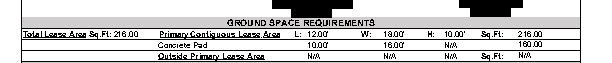

In [33]:
# table_crop = table_page.within_bbox((0, 35, table_page.width, 65))
table_crop = table_page.within_bbox((0, .11*table_page.height, table_page.width, .19*table_page.height))
tmp = table_crop.to_image()
tmp
# Extract the appropriate table
# tmp = []

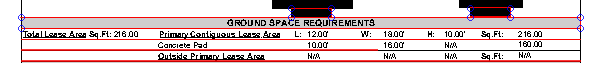

In [34]:
table_settings = {
    "vertical_strategy": "lines",
    "horizontal_strategy": "lines",
    "snap_y_tolerance": 5,
    "intersection_x_tolerance": 5,
}
tmp.reset().debug_tablefinder(table_settings)

In [29]:
table = table_crop.extract_tables(table_settings)
text = table_crop.extract_text_lines()
text[3]

NameError: name 'table_crop' is not defined

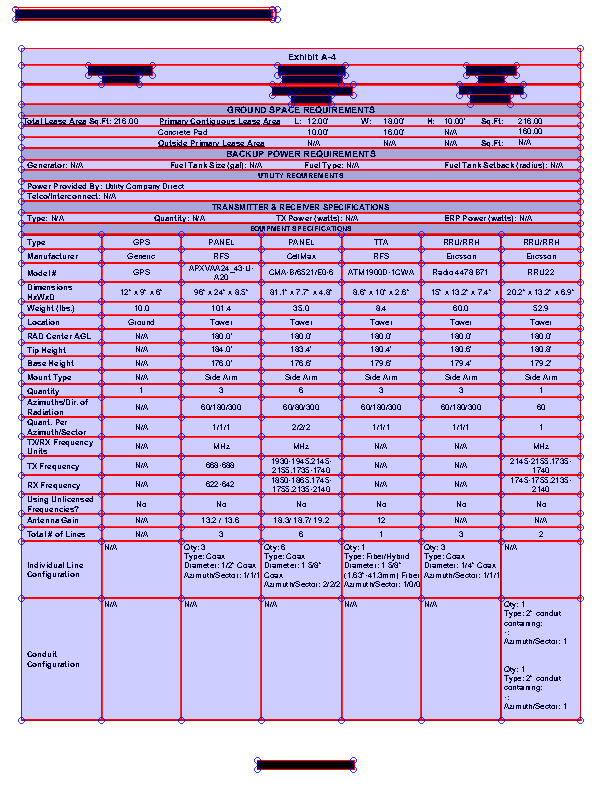

In [32]:
pdf = pdfplumber.open(original_pdf_path)
# Find the examined page
table_page = pdf.pages[0]
tmp = table_page.to_image()

# table_crop = table_page.crop((21.25, 600.272, 580.5, 687.772))
# table_crop.to_image()


In [34]:
# table_crop = table_page.within_bbox((0, 35, table_page.width, 65))
# table_crop = table_page.within_bbox()
# table_crop.to_image()
# table_crop
# Extract the appropriate table
tables = table_page.extract_tables()

In [44]:
tables[1]

[['Exhibit A-4', None, None, None, None, None, None],
 ['', None, None, None, None, None, None],
 ['', None, None, None, None, None, None],
 ['GROUND SPACE REQUIREMENTS', None, None, None, None, None, None],
 ["Total Lease Area Sq.Ft: 216.00 Primary Contiguous Lease Area L: 12.00' W: 18.00' H: 10.00' Sq.Ft: 216.00",
  None,
  None,
  None,
  None,
  None,
  None],
 ["Concrete Pad 10.00' 16.00' N/A 160.00", None, None, None, None, None, None],
 ['Outside Primary Lease Area N/A N/A N/A Sq.Ft: N/A',
  None,
  None,
  None,
  None,
  None,
  None],
 ['BACKUP POWER REQUIREMENTS', None, None, None, None, None, None],
 ['Generator: N/A Fuel Tank Size (gal): N/A Fuel Type: N/A Fuel Tank Setback (radius): N/A',
  None,
  None,
  None,
  None,
  None,
  None],
 ['UTILITY REQUIREMENTS', None, None, None, None, None, None],
 ['Power Provided By: Utility Company Direct',
  None,
  None,
  None,
  None,
  None,
  None],
 ['Telco/Interconnect: N/A', None, None, None, None, None, None],
 ['TRANSMITTER